In [46]:
# This notebook is about using neural style transfer to display a version of an image in the style of another image.
# Reference:
# https://www.tensorflow.org/tutorials/generative/style_transfer

import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [47]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [48]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [67]:
# Choose a content image and a style image.
content_path = tf.keras.utils.get_file('white_cat.png', 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/British_Longhair_Silver_Shaded_Point.jpg/800px-British_Longhair_Silver_Shaded_Point.jpg')
style_path = tf.keras.utils.get_file('mondrian.png', 'https://upload.wikimedia.org/wikipedia/commons/2/21/Piet_Mondriaan_-_Composition_with_red%2C_yellow%2C_black%2C_blue%2C_and_gray_-_1038646_-_Kunstmuseum_Den_Haag.jpg')

62363/62363 [==============================] - 0s 0us/step


In [68]:
# This is a function to load an image and limit its maximum dimension to 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [69]:
# This function displays an image.
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

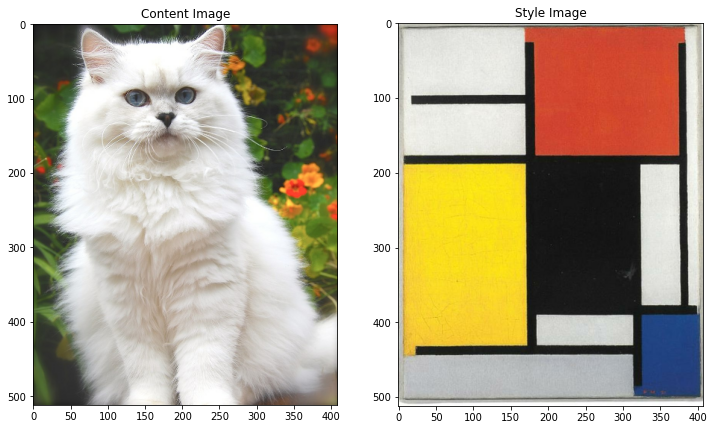

In [70]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

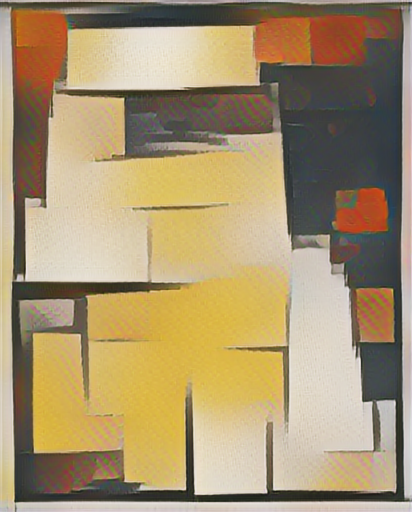

In [71]:
# A demonstration of fast style transfer:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [72]:
# Load a VGG19 (a pretrained image classification network) and perform a test run on our content image to ensure it's used correctly:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [73]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Persian_cat', 0.927745),
 ('lynx', 0.052373346),
 ('tabby', 0.0058503887),
 ('Egyptian_cat', 0.0025475374),
 ('tiger_cat', 0.0018363945)]

In [74]:
# Load a VGG19 without the classification head and list the layer names:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [75]:
# Choose intermediate layers from the neural network to represent the style and content of the image:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [76]:
# Build a VGG19 model that returns a list of intermediate layer outputs:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [77]:
# Create the model:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 407, 64)
  min:  0.0
  max:  875.3055
  mean:  34.35101

block2_conv1
  shape:  (1, 256, 203, 128)
  min:  0.0
  max:  3882.6453
  mean:  163.87286

block3_conv1
  shape:  (1, 128, 101, 256)
  min:  0.0
  max:  10996.823
  mean:  135.36563

block4_conv1
  shape:  (1, 64, 50, 512)
  min:  0.0
  max:  18485.928
  mean:  550.75305

block5_conv1
  shape:  (1, 32, 25, 512)
  min:  0.0
  max:  2802.3374
  mean:  46.54833



In [78]:
# Calculate a Gram matrix to describe the style of an image:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [79]:
# Build a model that returns the style and content tensors:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [80]:
# The model returns the Gram matrix (style) of an image's style_layers and content of its content_layers:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.018727327
    max:  71121.82
    mean:  313.89383

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  67809.23
    mean:  9138.195

   block3_conv1
    shape:  (1, 256, 256)
    min:  1.8066124
    max:  261899.33
    mean:  9259.861

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3730204.0
    mean:  160096.6

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  85855.32
    mean:  1324.963

Contents:
   block5_conv2
    shape:  (1, 32, 25, 512)
    min:  0.0
    max:  1525.3104
    mean:  14.272242


In [81]:
# Set the style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [82]:
# Define a tf.Variable to contain the image to optimize. Initialize it with the content image (the tf.Variable and the content image need to be the same size):
image = tf.Variable(content_image)

In [83]:
# Keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [84]:
# Create an optimizer:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [85]:
# For optimization, use a weighted combination of the two losses to get the total loss:
style_weight=1e-2
content_weight=1e4

In [86]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [87]:
# Use tf.GradientTape to update the image:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

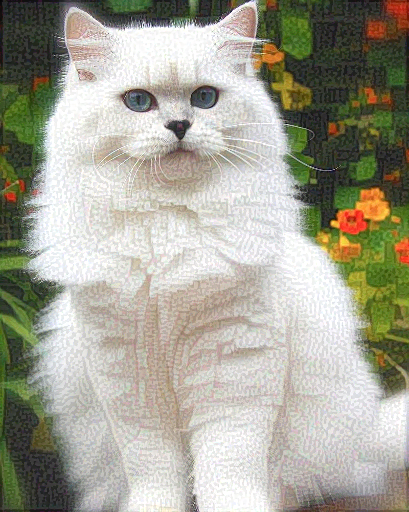

In [88]:
# Run a few steps to test:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

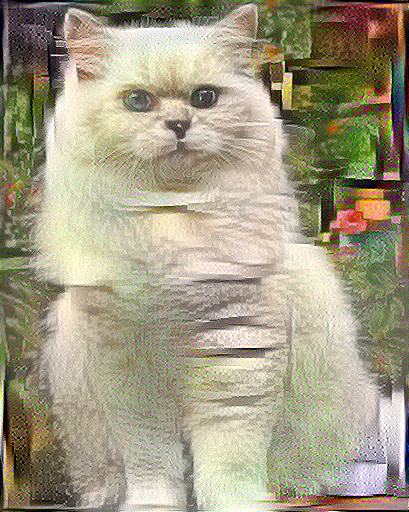

Train step: 15
Total time: 119.0


In [90]:
# Now perform a longer optimization:
import time
start = time.time()

epochs = 3 #10
steps_per_epoch = 5 #100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [91]:
# This function calculates the total variation loss:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

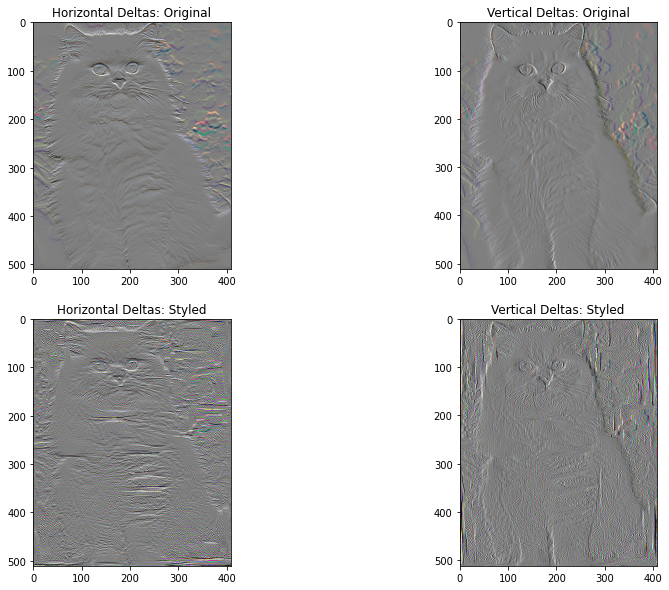

In [92]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

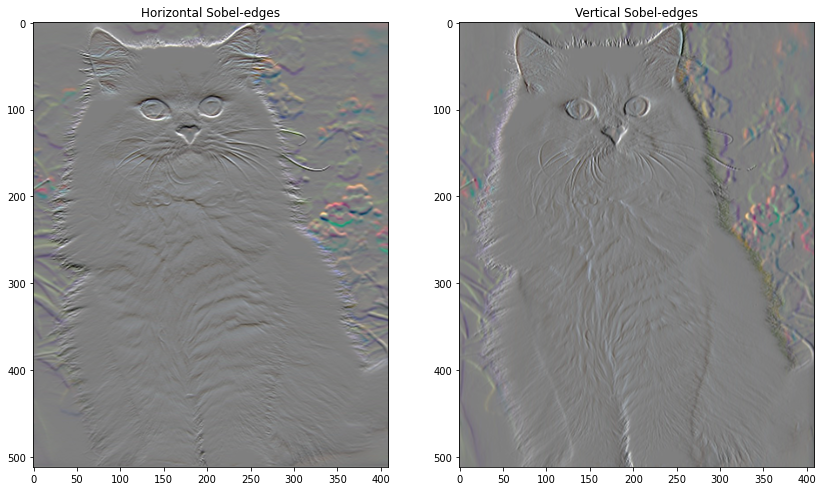

In [93]:
# Use the Sobel edge detector:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [94]:
# Calculate the regularization loss:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [95]:
total_variation_loss(image).numpy()

101048.1

In [96]:
# A standard implementation of total variation loss calculation:
tf.image.total_variation(image).numpy()

array([101048.1], dtype=float32)

In [97]:
# We're go to re-run the optimization. Choose a weight for the total_variation_loss:
total_variation_weight=30

In [98]:
# Include it in the train_step function:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [100]:
# Re-initialize the image-variable and the optimizer:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

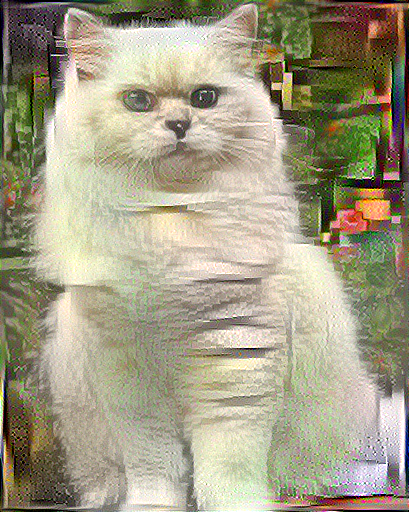

Train step: 150
Total time: 1181.8


In [103]:
# Run the optimization again:
import time
start = time.time()

epochs = 5 #10
steps_per_epoch = 30 #100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [104]:
# Save the result:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>